In [1]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Dropout, Conv2D, MaxPooling2D, Flatten, Dropout, BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.models import Sequential
from keras import backend as K
from keras.models import load_model
import keras

import numpy as np
import cv2 as cv
import matplotlib.pyplot as plt
import os
from PIL import Image

from sklearn.model_selection import train_test_split
from mlxtend.plotting import plot_confusion_matrix
from sklearn.metrics import confusion_matrix

In [2]:
# giving path of different folders
train_path = r'C:\Users\anike\Pneumonia detection model\chest_xray\train'
val_path = r'C:\Users\anike\Pneumonia detection model\chest_xray\val'
test_path = r'C:\Users\anike\Pneumonia detection model\chest_xray\test'

In [3]:
#labels

labels = ['NORMAL', 'PNEUMONIA']

In [4]:
#setting image size
image_size = 256

In [5]:
 #creating the training data
def process_data(data_dir, labels, image_size):             
    
    images = []
    for label in labels:
        dir = os.path.join(data_dir,label)

        class_num = labels.index(label)

        for image in os.listdir(dir):    #going through all the images in different folders and resizing them
            if image == '.DS_Store':
                continue
            image_read = cv.imread(os.path.join(dir,image),cv.IMREAD_GRAYSCALE)
            image_resized = cv.resize(image_read,(image_size,image_size))
            images.append([image_resized,class_num])
    return np.array(images)

In [6]:
train = process_data(train_path, labels, image_size)
test = process_data(test_path, labels, image_size)
val = process_data(val_path, labels, image_size)

C:\Users\anike\.conda\envs\arthenvnew\lib\site-packages\ipykernel_launcher.py:16: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  app.launch_new_instance()


In [7]:
train.shape

(5216, 2)

In [8]:
print('number of images in the training set:', train.shape[0])
print('number of images in the validation set:', val.shape[0])
print('number of images in the test set:', test.shape[0])

number of images in the training set: 5216
number of images in the validation set: 16
number of images in the test set: 624


In [9]:
X = []
y = []

for feature, label in train:
    X.append(feature)          #appending all images
    y.append(label)            #appending all labels

for feature, label in val:
    X.append(feature)
    y.append(label)

In [10]:
#Reshaping data in order to feed it into the Neural Network
X = np.array(X).reshape(-1, image_size, image_size, 1)
y = np.array(y)
y = np.expand_dims(y, axis =1)

In [11]:
#Concatenate train and val data

X_train, X_val, y_train, y_val = train_test_split(X,y, test_size=0.2, shuffle=True)

print('number of images in training set:', X_train.shape[0])
print('number of images in validation set:', X_val.shape[0])

number of images in training set: 4185
number of images in validation set: 1047


In [12]:
X_train.shape

(4185, 256, 256, 1)

In [13]:
count_normal = len([y for y in y_train if y == 0])
count_pneumonia = len([y for y in y_train if y == 1])

print('Count of NORMAL images in train:', count_normal)
print('Count of PNEUMONIA images in train:', count_pneumonia)


Count of NORMAL images in train: 1094
Count of PNEUMONIA images in train: 3091


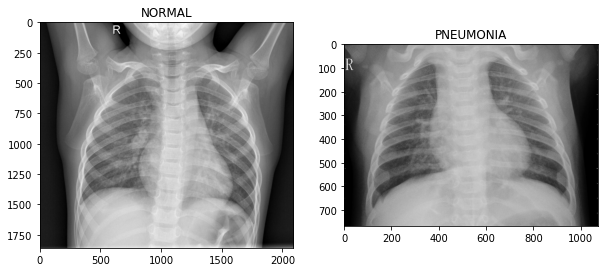

In [14]:
# Quick look to the images 

img_name = 'IM-0115-0001.jpeg'
img_normal = load_img(r'C:\Users\anike\Pneumonia detection model\chest_xray\train\NORMAL/' + img_name)

img_name_1 = 'person1000_virus_1681.jpeg'
img_pneumonia = load_img(r'C:\Users\anike\Pneumonia detection model\chest_xray\train\PNEUMONIA/' + img_name_1)

fig, axs = plt.subplots(1,2,figsize=(10,6))
axs[0].imshow(img_normal)
axs[0].set_title("NORMAL")
axs[1].imshow(img_pneumonia)
axs[1].set_title("PNEUMONIA");

In [15]:
img_height, img_width  = 180, 180
batch_size = 16


if K.image_data_format() == 'channels_first':
    input_shape = (3, img_width, img_height)
else:
    input_shape = (img_width, img_height, 3)

In [16]:
# Performing Image Augmentation to have more data samples

train_datagen = ImageDataGenerator(
    rescale=1. / 255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True)

test_datagen = ImageDataGenerator(rescale=1. / 255)
val_datagen = ImageDataGenerator(rescale=1. / 255)

train_generator = train_datagen.flow_from_directory(
    train_path,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='binary')

validation_generator = val_datagen.flow_from_directory(
    val_path,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='binary')

test_generator = test_datagen.flow_from_directory(
    test_path,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='binary')

Found 5216 images belonging to 2 classes.
Found 16 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


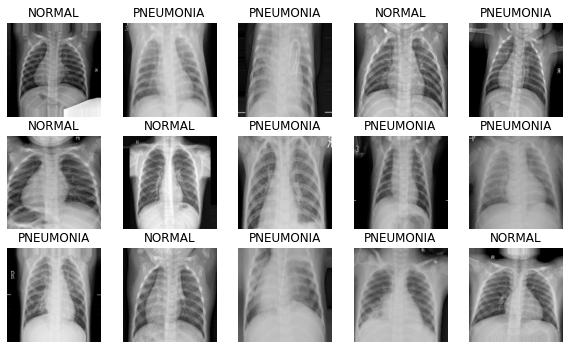

In [17]:
# Show some images after data augmentation

image_batch, label_batch = next(iter(train_generator))

def show_batch(image_batch, label_batch):
    plt.figure(figsize=(10, 10))
    for n in range(15):
        ax = plt.subplot(5, 5, n + 1)
        plt.imshow(image_batch[n], cmap='gray')
        if label_batch[n]:
            plt.title("PNEUMONIA")
        else:
            plt.title("NORMAL")
        plt.axis("off")

show_batch(image_batch, label_batch)

In [18]:
#creating the CNN model
classifier = Sequential()

In [19]:
classifier.add(Conv2D(filters=32, kernel_size=(3,3), strides=1, input_shape=(image_size,image_size,1), activation='relu', padding='same'))
classifier.add(BatchNormalization())
classifier.add(Conv2D(filters=32, kernel_size=(3,3), strides=1, input_shape=(image_size,image_size,1), activation='relu', padding='same'))
classifier.add(BatchNormalization())   
classifier.add(MaxPooling2D(2,2))                                       

classifier.add(Conv2D(filters=64, kernel_size=(3,3), strides=1, input_shape=(image_size,image_size,1), activation='relu', padding='same'))
classifier.add(BatchNormalization())
classifier.add(Conv2D(filters=64, kernel_size=(3,3), strides=1, input_shape=(image_size,image_size,1), activation='relu', padding='same'))
classifier.add(BatchNormalization())   
classifier.add(MaxPooling2D(2,2))      

classifier.add(Conv2D(filters=128, kernel_size=(3,3), strides=1, input_shape=(image_size,image_size,1), activation='relu', padding='same'))
classifier.add(BatchNormalization())
classifier.add(Conv2D(filters=128, kernel_size=(3,3), strides=1, input_shape=(image_size,image_size,1), activation='relu', padding='same'))
classifier.add(BatchNormalization())   
classifier.add(MaxPooling2D(2,2))      

classifier.add(Conv2D(filters=256, kernel_size=(3,3), strides=1, input_shape=(image_size,image_size,1), activation='relu', padding='same'))
classifier.add(BatchNormalization())
classifier.add(Conv2D(filters=256, kernel_size=(3,3), strides=1, input_shape=(image_size,image_size,1), activation='relu', padding='same'))
classifier.add(BatchNormalization())   
classifier.add(MaxPooling2D(2,2))      

classifier.add(Flatten())     

classifier.add(Dense(units=512, activation='relu'))
classifier.add(Dropout(0.4))

classifier.add(Dense(units=512, activation='relu'))
classifier.add(Dropout(0.3))

classifier.add(Dense(units=512, activation='relu'))
classifier.add(Dropout(0.1))

classifier.add(Dense(units=1, activation='sigmoid'))

In [20]:
classifier.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 256, 256, 32)      320       
_________________________________________________________________
batch_normalization (BatchNo (None, 256, 256, 32)      128       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 256, 256, 32)      9248      
_________________________________________________________________
batch_normalization_1 (Batch (None, 256, 256, 32)      128       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 128, 128, 32)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 128, 128, 64)      18496     
_________________________________________________________________
batch_normalization_2 (Batch (None, 128, 128, 64)      2

In [21]:
batch_size = 4

train_gen = ImageDataGenerator(rotation_range=10,
                                   horizontal_flip = True,
                                   width_shift_range=0.1,
                                   height_shift_range=0.1,
                                   rescale=1.,
                                   zoom_range=0.2,
                                   fill_mode='nearest',
                                   cval=0)

train_generator = train_gen.flow(X_train,y_train,batch_size)
steps_per_epoch = X_train.shape[0]//batch_size

In [22]:
#to save the best performing model
checkpoint = ModelCheckpoint('Pneumonia_model.h5', monitor='val_loss', verbose=1, save_best_only=True, mode='auto')

In [23]:
classifier.compile(optimizer = Adam(lr = 0.00001), loss = 'binary_crossentropy', metrics = ['accuracy']) 

In [24]:
history=classifier.fit(train_generator, validation_data=(X_val, y_val), steps_per_epoch = steps_per_epoch, epochs= 10,
                       callbacks = [checkpoint])

Epoch 1/10
  92/1046 [=>............................] - ETA: 14:53 - loss: 0.6323 - accuracy: 0.7092

KeyboardInterrupt: 

In [ ]:
plt.plot(history.history['loss'],label='loss')
plt.plot(history.history['val_loss'],label='val_loss')
plt.legend()

In [ ]:
plt.plot(history.history['accuracy'],label='accuracy')
plt.plot(history.history['val_accuracy'],label='val_accuracy')
plt.legend()

In [ ]:
final_model = tf.keras.models.load_model('Pneumonia_model.h5')

In [ ]:
X_test = []
y_test = []
# Preproccessing test set
for feature, label in test:
    X_test.append(feature)
    y_test.append(label)
#Reshaping data in order to feed it into the Neural Network
X_test = np.array(X_test).reshape(-1, image_size, image_size, 1)
y_test = np.array(y_test)
y_test = np.expand_dims(y_test, axis =1)

In [ ]:
pred = final_model.predict(X_test, batch_size = 8)

In [ ]:
pred_final = np.where(pred>0.5,1,0)

# Plotting Confusion Matrix

In [ ]:
X_test.shape

In [ ]:
# Get the confusion matrix
CM = confusion_matrix(y_test, pred_final)

fig, ax = plot_confusion_matrix(conf_mat=CM ,  figsize=(8,8))
plt.title('Confusion matrix')
plt.xticks(range(2), ['Normal','Pneumonia'], fontsize=10)
plt.yticks(range(2), ['Normal','Pneumonia'], fontsize=10)
plt.show()

In [ ]:
def perf_measure(y_test, pred_final):
    TP = 0
    FP = 0
    TN = 0
    FN = 0

    for i in range(len(pred_final)): 
        if y_test[i]==pred_final[i]==1:
           TP += 1
        if y_test[i]==0 and y_test[i]!=pred_final[i]:
           FP += 1
        if y_test[i]==pred_final[i]==0:
           TN += 1
        if y_test[i]==1 and y_test[i]!=pred_final[i]:
           FN += 1

    return(TP, FP, TN, FN)

In [ ]:
tp, fp, tn ,fn = perf_measure(y_test,pred_final)

precision = tp/(tp+fp)
recall = tp/(tp+fn)
f_score = (2*precision*recall)/(precision+recall)

print("Recall of the model is {:.2f}".format(recall))
print("Precision of the model is {:.2f}".format(precision))
print("F-Score is {:.2f}".format(f_score))

In [ ]:
def predict_image(filename):
    img = load_img(filename, target_size=(256, 256))
    image = keras.preprocessing.image.img_to_array(img)
    image = image / 255.0
    image = image.reshape(-1,256,256,1)
    model = load_model('Pneumonia_model.h5')
    prediction = model.predict(image, batch_size=8)
    plt.imshow(img)
    if(prediction[0] > 0.7):
        print(prediction[0])
        print("predicted: PNEUMONIA")
    else:
        print(prediction[0])
        print("predicted: NORMAL")
        

In [ ]:
predict_image(r"C:\Users\anike\Pneumonia detection model\chest_xray\test\PNEUMONIA\person1_virus_7.jpeg")